# Neurodesign base functions overview

This tutorial walks you through `neurodesign`, a Python package for generating and optimizing fMRI experimental designs. By the end, you will understand how to:

1. **Define an experiment** — specify TR, trials, contrasts, ITI distributions, and other parameters.
2. **Create and evaluate designs manually** — build trial sequences by hand and compute efficiency metrics.
3. **Use genetic operators** — apply crossover and mutation to combine and explore designs.
4. **Run automatic optimization** — use the genetic algorithm (GA) and simulation-based search to find optimal designs.
5. **Compare optimization strategies** — benchmark GA, simulation, and random designs using simulated statistical power.
6. **Export a PDF report** — generate a summary of your optimization results.

Code adapted from the [neurodesign examples](https://github.com/neuropower/neurodesign/tree/master/examples).

---

In [1]:
import os

# Limit threads — neurodesign uses multi-threading internally
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

from collections import Counter
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import neurodesign
from neurodesign import Experiment, Design, Optimisation, generate, report

# Configure matplotlib for inline plotting
%matplotlib inline

In [2]:
# Create a shared output directory for all results
output_dir = Path("./output/neurodesign_tutorial")
output_dir.mkdir(parents=True, exist_ok=True)

---

## 1 — Key Concepts and Objects

Neurodesign is built around three core classes:

| Class | Purpose |
|---|---|
| `Experiment` | Defines the experimental context: TR, number of trials, contrasts, ITI model, etc. |
| `Design` | A specific trial sequence (order + ITIs) that can be evaluated for efficiency. |
| `Optimisation` | Runs a search algorithm (GA or simulation) over the space of possible designs. |

---

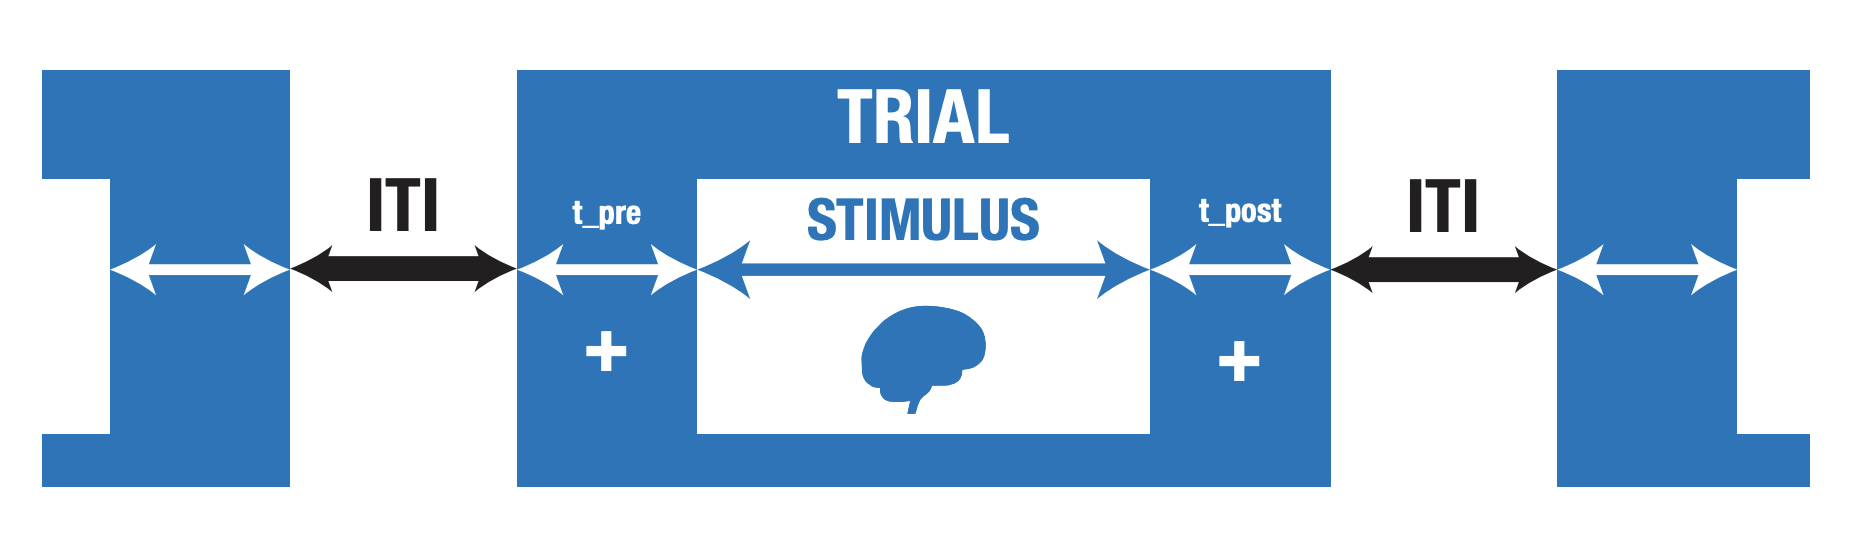

*Image from the [neurodesign preprint](https://www.biorxiv.org/content/10.1101/119594v2) on BioRxiv*

In [3]:
from IPython.display import Image, display, Markdown

display(Image(filename='./docs/_images/neurodesign_trial_structure.png'))
display(Markdown('*Image from the [neurodesign preprint](https://www.biorxiv.org/content/10.1101/119594v2) on BioRxiv*'))

### Efficiency Metrics

Neurodesign evaluates designs on four metrics:

| Metric | Name | What It Measures |
|---|---|---|
| **Fd** | Detection efficiency | How well the design detects condition differences (statistical power for contrasts). |
| **Fe** | Estimation efficiency | How well the design estimates the shape/amplitude of the HRF for each condition. |
| **Fc** | Confounding (collinearity) | How correlated the condition regressors are. Lower is better. |
| **Ff** | Frequency balance | How closely stimulus frequencies match the desired probabilities. Lower is better. |

These are combined into a single score **F** using user-specified weights: `weights = [w_Fe, w_Fd, w_Fc, w_Ff]`.

---

## 2 — Defining an Experiment

The `Experiment` object encapsulates all the parameters that are fixed across designs: the fMRI acquisition setup, the contrasts of interest, and the ITI model.

Here we define a simple experiment with 3 conditions and 20 trials.

In [22]:
# Create a simple experiment
exp = Experiment(
    TR=2,                    # Repetition Time (in seconds) - how often we acquire brain images
    n_trials=20,             # Total number of trials in the experiment
    P=[0.3, 0.3, 0.4],       # Probabilities for 3 conditions (must sum to 1.0)
    C=[[1, -1, 0],           # Contrast matrix: what comparisons are we interested in?
       [0, 1, -1]],          # e.g., condition 1 vs 2, and condition 2 vs 3
    n_stimuli=3,             # Number of distinct stimuli/conditions
    rho=0.3,                 # Autocorrelation in noise (typical fMRI value)
    resolution=0.1,          # Temporal resolution for design matrix
    stim_duration=1,         # How long each stimulus is presented (in seconds)
    t_pre=0.5,               # Time before stimulus onset (e.g., fixation)
    t_post=2,                # Time after stimulus offset (e.g., response period)
    ITImodel="exponential",  # Model for inter-trial intervals
    ITImin=2,                # Minimum ITI (in seconds)
    ITImean=2.1,             # Mean ITI (in seconds)
    ITImax=4,                # Maximum ITI (in seconds)
)

print("✓ Experiment created successfully")
print(f"  - {exp.n_trials} trials")
print(f"  - {exp.n_stimuli} conditions")
print(f"  - TR = {exp.TR}s")
print(f"  - ITI range: {exp.ITImin}-{exp.ITImax}s")

✓ Experiment created successfully
  - 20 trials
  - 3 conditions
  - TR = 2s
  - ITI range: 2-4s


**Key parameters explained:**

- **C (contrast matrix):** Each row defines a linear contrast over conditions. `[1, -1, 0]` tests condition 1 vs. condition 2.
- **P (probabilities):** Controls how often each condition appears. Unequal probabilities can improve detection of rare conditions but may hurt frequency balance.
- **ITImodel:** Can be `"exponential"` or `"uniform"`. Exponential ITIs decorrelate regressors and generally improve estimation efficiency.
- **rho:** The AR(1) autocorrelation coefficient for the noise model used in efficiency calculations.

---

## 3 — Creating and Evaluating Designs Manually

Before running any optimization, it is instructive to build designs by hand and see how structure choices affect efficiency.

### Design 1: Cyclic order + fixed ITI

Conditions repeat in a fixed cycle `[0, 1, 2, 0, 1, 2, ...]` 6 times, followed by `[0, 1]`. The task has a constant 2-second ITI. This is balanced but highly predictable and lacks temporal variability.

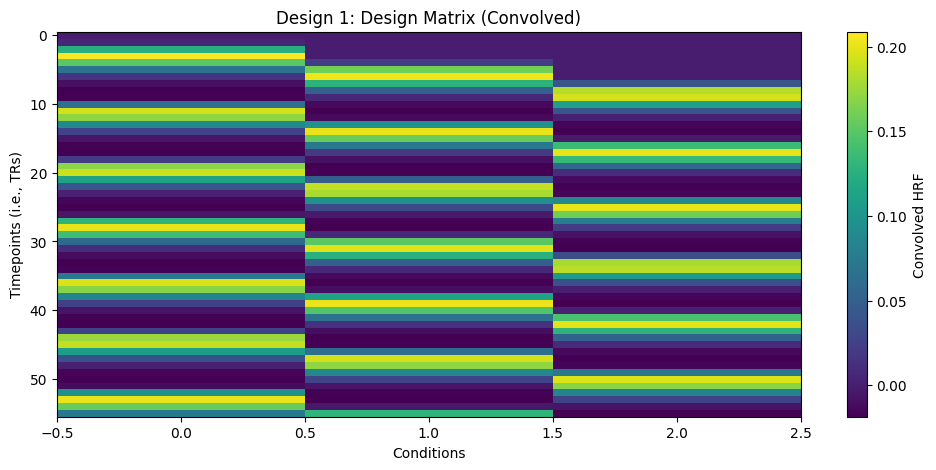

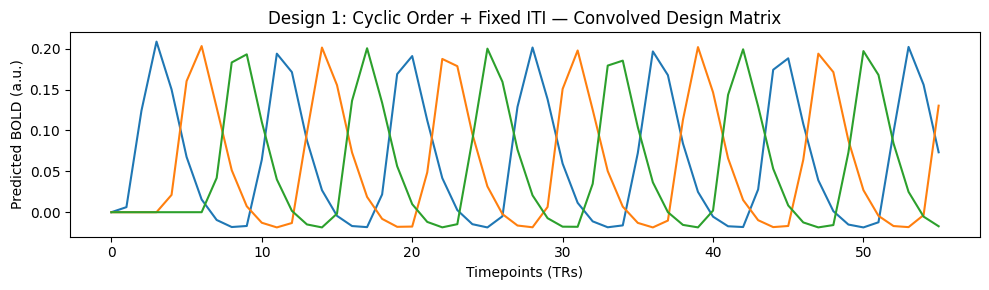

Fe (estimation efficiency): 115.2989
Fd (detection efficiency):  0.1659
Fc (collinearity):          0.2902
Ff (frequency balance):     0.8571


In [26]:
design_1 = Design(
    order=[0, 1, 2] * 6 + [0, 1],   # 20 trials in cyclic order
    ITI=[2] * 20,                    # Fixed 2s ITI
    experiment=exp,
)

# Build the convolved design matrix (stimulus model * HRF)
design_1.designmatrix()

plt.figure(figsize=(12, 5))
plt.imshow(design_1.Xconv, aspect='auto', cmap='viridis')
plt.colorbar(label='Convolved HRF')
plt.title("Design 1: Design Matrix (Convolved)")
plt.xlabel("Conditions")
plt.ylabel("Timepoints (i.e., TRs)")
plt.show()

# Compute all efficiency metrics
design_1.FCalc(weights=[0, 0.5, 0.25, 0.25])
design_1.FeCalc()
design_1.FdCalc()
design_1.FcCalc()
design_1.FfCalc()

plt.figure(figsize=(10, 3))
plt.plot(design_1.Xconv)
plt.title("Design 1: Cyclic Order + Fixed ITI — Convolved Design Matrix")
plt.xlabel("Timepoints (TRs)")
plt.ylabel("Predicted BOLD (a.u.)")
plt.tight_layout()
plt.show()

print(f"Fe (estimation efficiency): {design_1.Fe:.4f}")
print(f"Fd (detection efficiency):  {design_1.Fd:.4f}")
print(f"Fc (collinearity):          {design_1.Fc:.4f}")
print(f"Ff (frequency balance):     {design_1.Ff:.4f}")

### Design 2: Blocked order + jittered ITI

Conditions are grouped in blocks (`[0, 0, 0, 0, 0, 0, 1, ...]`) and ITIs are drawn from an exponential distribution. The blocking structure generally .

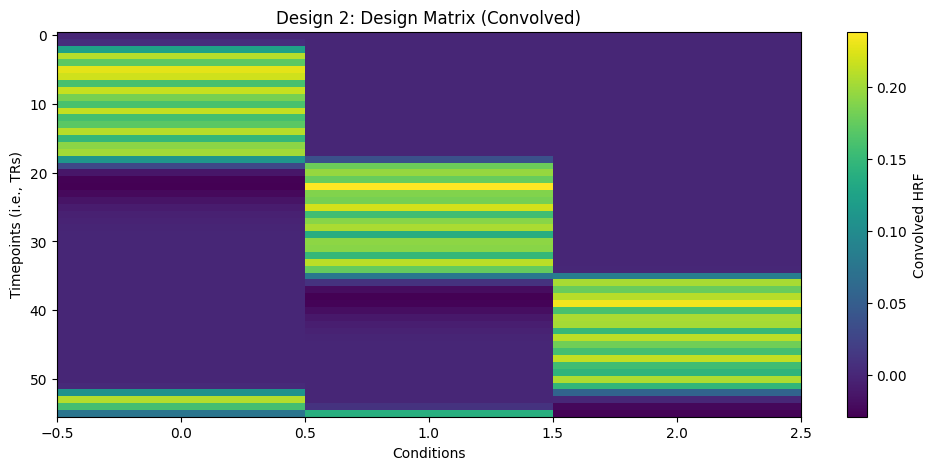

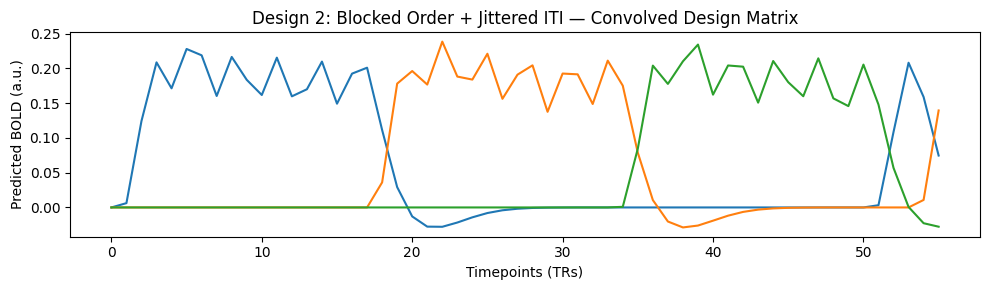

Fe (estimation efficiency): 150.6423
Fd (detection efficiency):  0.1113
Fc (collinearity):          0.5978
Ff (frequency balance):     0.8571


In [29]:
design_2 = Design(
    order=[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2] + [0, 1],  # Blocked condition order, 20 trials
    ITI=generate.iti(                          # Jittered ITIs
        ntrials=20, model="exponential",
        min=1, mean=2, max=3, seed=2026
    )[0],
    experiment=exp,
)

design_2.designmatrix()

plt.figure(figsize=(12, 5))
plt.imshow(design_2.Xconv, aspect='auto', cmap='viridis')
plt.colorbar(label='Convolved HRF')
plt.title("Design 2: Design Matrix (Convolved)")
plt.xlabel("Conditions")
plt.ylabel("Timepoints (i.e., TRs)")
plt.show()

design_2.FeCalc()
design_2.FdCalc()
design_2.FcCalc()
design_2.FfCalc()

plt.figure(figsize=(10, 3))
plt.plot(design_2.Xconv)
plt.title("Design 2: Blocked Order + Jittered ITI — Convolved Design Matrix")
plt.xlabel("Timepoints (TRs)")
plt.ylabel("Predicted BOLD (a.u.)")
plt.tight_layout()
plt.show()

print(f"Fe (estimation efficiency): {design_2.Fe:.4f}")
print(f"Fd (detection efficiency):  {design_2.Fd:.4f}")
print(f"Fc (collinearity):          {design_2.Fc:.4f}")
print(f"Ff (frequency balance):     {design_2.Ff:.4f}")

### Design 3: Mini-Blocked order + jittered ITI

Conditions are grouped in mini-blocks (`[0, 0, 1, 1, 2, 2, ...]`) and ITIs are drawn from an exponential distribution. The temporal variability from jittered ITIs decorrelates the regressors and generally improves estimation efficiency.

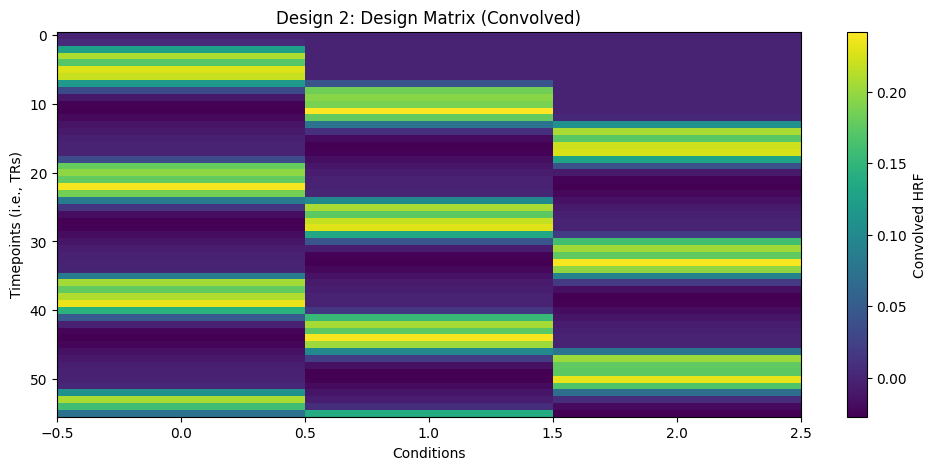

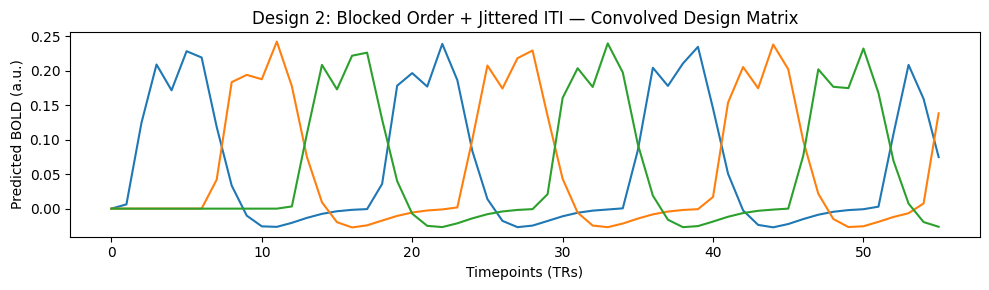

Fe (estimation efficiency): 163.3180
Fd (detection efficiency):  0.1931
Fc (collinearity):          0.5548
Ff (frequency balance):     0.8571


In [30]:
design_3 = Design(
    order=[0, 0, 1, 1, 2, 2] * 3 + [0, 1],  # Blocked condition order
    ITI=generate.iti(                          # Jittered ITIs
        ntrials=20, model="exponential",
        min=1, mean=2, max=3, seed=2026
    )[0],
    experiment=exp,
)

design_3.designmatrix()

plt.figure(figsize=(12, 5))
plt.imshow(design_3.Xconv, aspect='auto', cmap='viridis')
plt.colorbar(label='Convolved HRF')
plt.title("Design 2: Design Matrix (Convolved)")
plt.xlabel("Conditions")
plt.ylabel("Timepoints (i.e., TRs)")
plt.show()

design_3.FeCalc()
design_3.FdCalc()
design_3.FcCalc()
design_3.FfCalc()

plt.figure(figsize=(10, 3))
plt.plot(design_3.Xconv)
plt.title("Design 2: Blocked Order + Jittered ITI — Convolved Design Matrix")
plt.xlabel("Timepoints (TRs)")
plt.ylabel("Predicted BOLD (a.u.)")
plt.tight_layout()
plt.show()

print(f"Fe (estimation efficiency): {design_3.Fe:.4f}")
print(f"Fd (detection efficiency):  {design_3.Fd:.4f}")
print(f"Fc (collinearity):          {design_3.Fc:.4f}")
print(f"Ff (frequency balance):     {design_3.Ff:.4f}")

### Comparing the two designs

- Design 1 (cyclic + fixed ITI) tends to have high **detection power (Fd)** because the regular alternation produces well-separated condition regressors.  
- Design 2 (blocked + jittered ITI) tends to have higher **estimation efficiency (Fe)** because temporal jitter decorrelates regressors and helps estimate HRF shapes more precisely.  
- Design 3 (mini-blocks + jittered ITI) seems to achieve a compromise.

This illustrates a fundamental trade-off in fMRI design: detection and estimation efficiency often pull in different directions. Optimization can help find a balance.

---

## 4 — Genetic Operators: Crossover and Mutation

Neurodesign uses evolutionary/genetic-algorithm concepts to search the design space. Two key operators are:

- **Crossover:** Combine elements of two parent designs to create hybrid offspring.
- **Mutation:** Randomly alter part of a design to introduce variation.

### Crossover

We cross Design 1 and Design 2 to produce two offspring that inherit features from both parents.

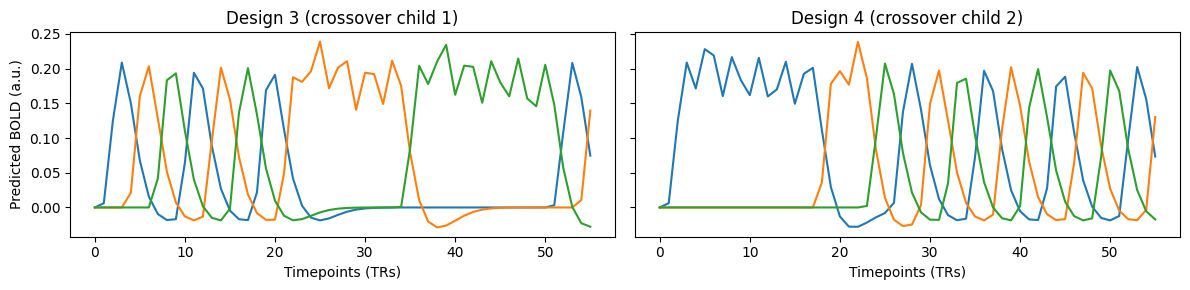

In [31]:
design_3, design_4 = design_1.crossover(design_2, seed=2000)

# Evaluate both offspring
for d, label in [(design_3, "Design 3 (crossover child 1)"),
                 (design_4, "Design 4 (crossover child 2)")]:
    d.designmatrix()
    d.FeCalc()
    d.FdCalc()
    d.FcCalc()
    d.FfCalc()

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
axes[0].plot(design_3.Xconv)
axes[0].set_title("Design 3 (crossover child 1)")
axes[1].plot(design_4.Xconv)
axes[1].set_title("Design 4 (crossover child 2)")
for ax in axes:
    ax.set_xlabel("Timepoints (TRs)")
axes[0].set_ylabel("Predicted BOLD (a.u.)")
plt.tight_layout()
plt.show()

### Mutation

A mutation randomly flips a fraction of the trial labels in a design. Here we apply a 30% mutation rate to Design 1.

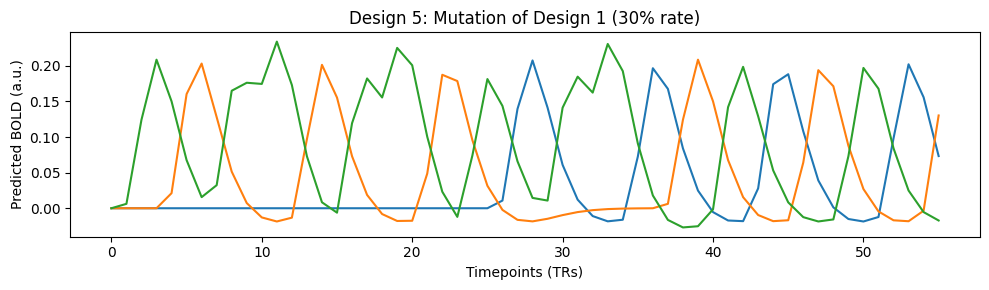

In [32]:
design_5 = design_1.mutation(0.3, seed=2000)

design_5.designmatrix()
design_5.FeCalc()
design_5.FdCalc()
design_5.FcCalc()
design_5.FfCalc()

plt.figure(figsize=(10, 3))
plt.plot(design_5.Xconv)
plt.title("Design 5: Mutation of Design 1 (30% rate)")
plt.xlabel("Timepoints (TRs)")
plt.ylabel("Predicted BOLD (a.u.)")
plt.tight_layout()
plt.show()

### Summary: Comparing all five designs

In [33]:
designs = {
    "Design 1 (cyclic + fixed ITI)": design_1,
    "Design 2 (blocked + jittered ITI)": design_2,
    "Design 3 (crossover child 1)": design_3,
    "Design 4 (crossover child 2)": design_4,
    "Design 5 (mutation of D1)": design_5,
}

print(f"{'Design':<38} {'Fe':>8} {'Fd':>8} {'Fc':>8} {'Ff':>8}")
print("-" * 74)
for name, d in designs.items():
    print(f"{name:<38} {d.Fe:>8.4f} {d.Fd:>8.4f} {d.Fc:>8.4f} {d.Ff:>8.4f}")

Design                                       Fe       Fd       Fc       Ff
--------------------------------------------------------------------------
Design 1 (cyclic + fixed ITI)          115.2989   0.1659   0.2902   0.8571
Design 2 (blocked + jittered ITI)      150.6423   0.1113   0.5978   0.8571
Design 3 (crossover child 1)           166.1493   0.1392   0.6782   0.8571
Design 4 (crossover child 2)           178.3988   0.1384   0.5022   0.7143
Design 5 (mutation of D1)              171.8818   0.1357   0.5908   0.8571


Crossover and mutation let us explore the design space beyond what hand-crafted sequences can reach. But doing this manually for a handful of designs is tedious — which is exactly what automatic optimization solves.

---

## 5 — Utility Functions: Generating Orders and ITIs

Neurodesign provides helper functions in `neurodesign.generate` for creating trial orders and ITI sequences programmatically.

### Random trial order

In [34]:
order = generate.order(
    nstim=4,
    ntrials=100,
    probabilities=[0.25, 0.25, 0.25, 0.25],
    ordertype="random",
    seed=1234,
)

print("First 10 trials:", order[:10])
print("Condition counts:", dict(Counter(order)))

First 10 trials: [3, 0, 0, 2, 0, 0, 2, 2, 2, 0]
Condition counts: {3: 20, 0: 36, 2: 22, 1: 22}


### Jittered ITI from exponential distribution

Mean ITI: 2.92s | Min: 0.00s | Max: 6.90s


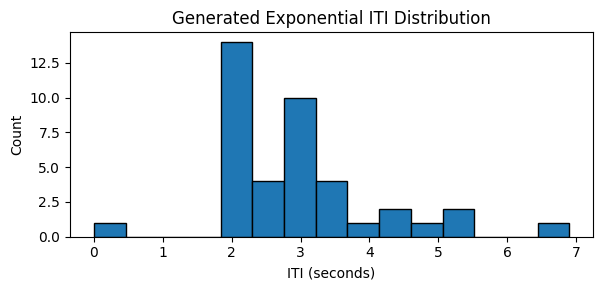

In [35]:
iti_values, lam = generate.iti(
    ntrials=40,
    model="exponential",
    min=2,
    mean=3,
    max=8,
    resolution=0.1,
    seed=2134,
)

print(f"Mean ITI: {np.mean(iti_values):.2f}s | "
      f"Min: {min(iti_values):.2f}s | "
      f"Max: {max(iti_values):.2f}s")

plt.figure(figsize=(6, 3))
plt.hist(iti_values, bins=15, edgecolor="black")
plt.title("Generated Exponential ITI Distribution")
plt.xlabel("ITI (seconds)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

---

## 6 — Automatic Optimization with the Genetic Algorithm

The `Optimisation` class automates the search over trial orders and ITIs. It maintains a population of designs, evaluates them, and iteratively applies selection, crossover, and mutation to evolve better designs.

### Setting up the experiment

We define a larger, more realistic experiment for the optimization examples.

In [36]:
exp_optim = Experiment(
    TR=2,
    n_trials=100,
    P=[0.33, 0.33, 0.33],
    C=[[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, -1, 0], [0, 1, -1]],
    n_stimuli=3,
    rho=0.3,
    resolution=0.1,
    stim_duration=1,
    t_pre=0,
    t_post=2,
    restnum=0,
    restdur=0,
    ITImodel="exponential",
    ITImin=1,
    ITImean=2,
    ITImax=4,
)

c:\Users\vguigon\Desktop\Research_directory\research_tests\neurodesign-plus\neurodesign\classes.py:635: UserWarning: the resolution is adjusted to be a multiple of the TR. New resolution: 0.1
  warnings.warn(
c:\Users\vguigon\Desktop\Research_directory\research_tests\neurodesign-plus\neurodesign\classes.py:809: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


### Running the optimization

The `Optimisation` object is configured with:

- **weights:** Relative importance of `[Fe, Fd, Fc, Ff]` in the combined score.
- **preruncycles / cycles:** Number of warm-up and main iterations.
- **seed:** For reproducibility.
- **outdes:** How many top designs to keep.

In [37]:
population = Optimisation(
    experiment=exp_optim,
    weights=[0, 0.5, 0.25, 0.25],  # Emphasize detection efficiency
    preruncycles=10,                # Warm-up cycles
    cycles=10,                      # Main optimization cycles
    seed=1,
    outdes=5,                       # Keep top 5 designs
    folder=output_dir,
)

population.optimise()   # Run the genetic algorithm
population.download()   # Save top designs
population.evaluate()   # Evaluate final results

c:\Users\vguigon\Desktop\Research_directory\research_tests\neurodesign-plus\venv\Lib\site-packages\rich\live.py:231
: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

### Inspecting the best design

Fd (detection efficiency):      0.9663
Fe (estimation efficiency):     N/A
Fc (confounding / collinearity): 0.9371
Ff (frequency balance):          0.9925


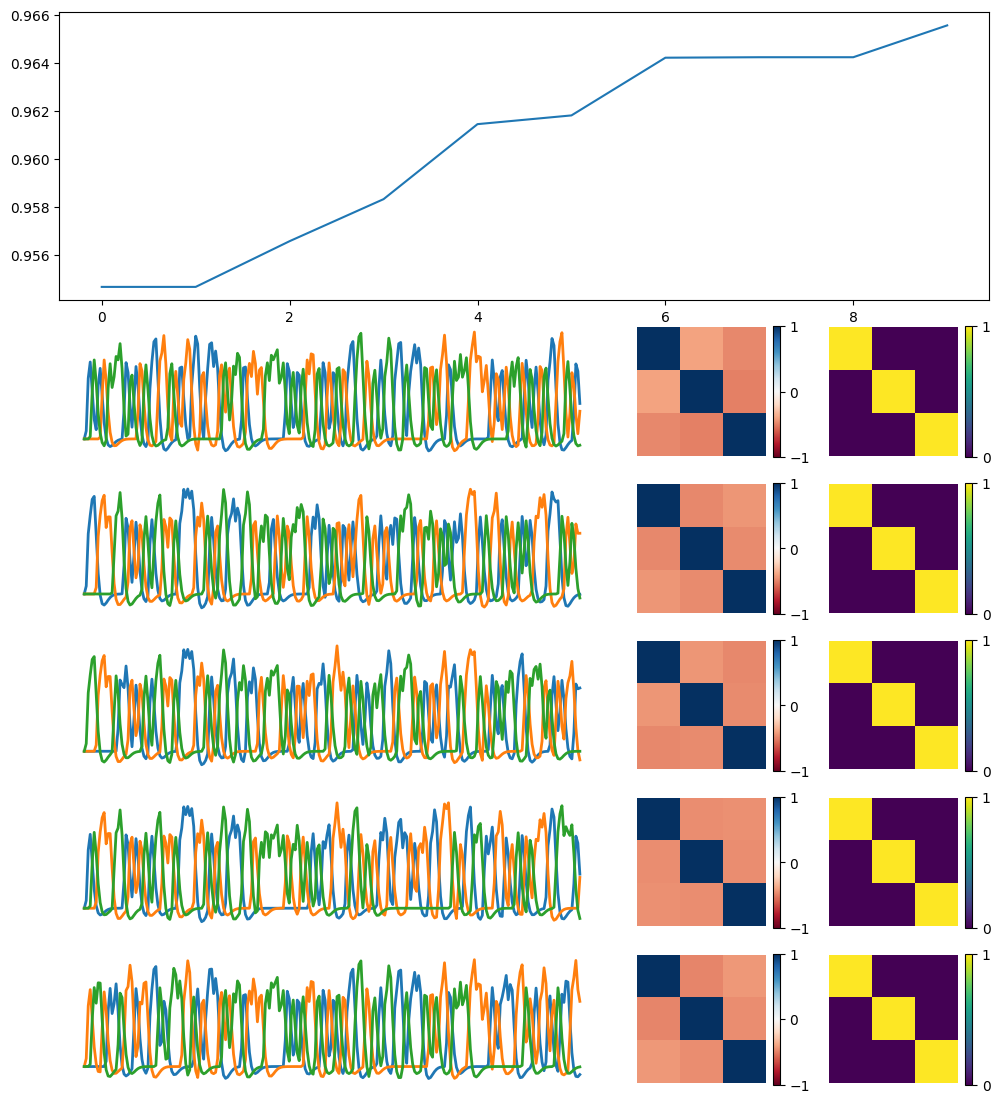

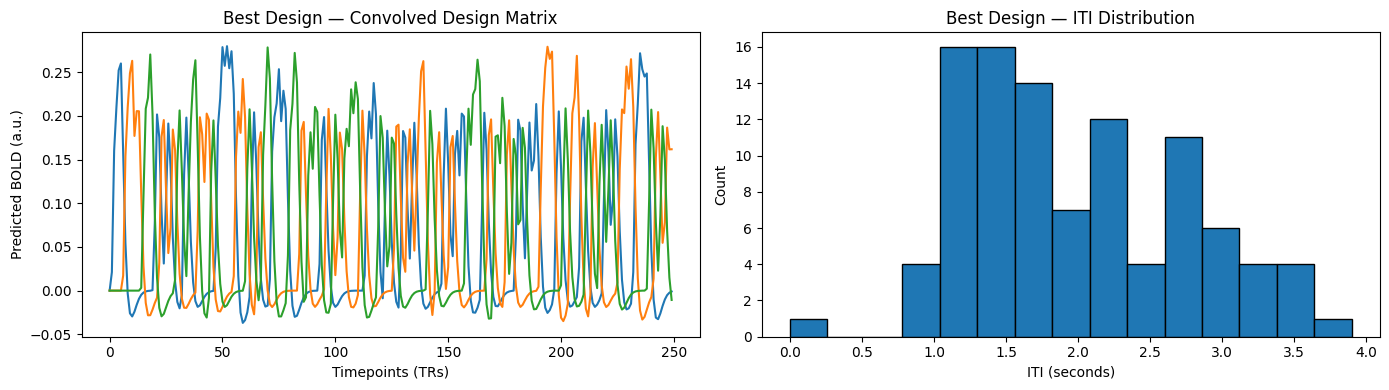

Stimulus order: [np.int32(0), 0, 1, 1, 1, 2, np.int32(2), 0, 1, np.int32(0), 1, 2, 0, 2, 2, 1, 1, 2, 0, 0, 0, 0, 1, 1, 2, 0, 1, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 0, 1, 2, 1, np.int32(2), np.int32(2), 2, 1, 0, 0, 2, 0, 2, 1, 0, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 2, 2, 2, 0, 1, 2, 2, 1, 2, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 1, 0, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 0, 0, 2, 1, 2, 1, 1]
ITI sequence: [np.float64(0.0), np.float64(1.5), np.float64(2.7), np.float64(1.5), np.float64(2.6), np.float64(3.5), np.float64(1.6), np.float64(2.7), np.float64(1.6), np.float64(2.0), np.float64(1.5), np.float64(2.0), np.float64(3.0), np.float64(1.3), np.float64(1.2), np.float64(1.6), np.float64(3.6), np.float64(1.3), np.float64(2.3), np.float64(1.3), np.float64(1.1), np.float64(1.0), np.float64(1.1), np.float64(2.4), np.float64(1.8), np.float64(1.1), np.float64(2.2), np.float64(1.2), np.float64(1.1), np.float64(1.0), np.float64(2.0), np.float64(2.2), np.float64(2.4), np.float64(1.4), np.float64(2.7), np.float64(3.4), np.flo

In [38]:
best = population.bestdesign

print(f"Fd (detection efficiency):      {best.Fd:.4f}")
print(f"Fe (estimation efficiency):     {best.Fe if hasattr(best, 'Fe') and best.Fe else 'N/A'}")
print(f"Fc (confounding / collinearity): {best.Fc:.4f}")
print(f"Ff (frequency balance):          {best.Ff:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Convolved design matrix as line plot
axes[0].plot(best.Xconv)
axes[0].set_title("Best Design — Convolved Design Matrix")
axes[0].set_xlabel("Timepoints (TRs)")
axes[0].set_ylabel("Predicted BOLD (a.u.)")

# ITI distribution
axes[1].hist(best.ITI, bins=15, edgecolor="black")
axes[1].set_title("Best Design — ITI Distribution")
axes[1].set_xlabel("ITI (seconds)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

print("Stimulus order:", best.order)
print("ITI sequence:", [round(x, 2) for x in best.ITI])

### Step-by-step evolution (advanced)

You can also control the evolutionary process manually, which is useful for debugging or custom stopping criteria.

In [39]:
# Add fresh random designs to the current population
population.add_new_designs()

# Manually advance by one generation at a time
population.to_next_generation(seed=1)
population.to_next_generation(seed=1001)

### Exporting a PDF report

Neurodesign can generate a PDF summarizing the optimization results.

In [40]:
report.make_report(population, output_dir / "optimization_report.pdf")
print(f"Report saved to: {output_dir / 'optimization_report.pdf'}")

Report saved to: output\neurodesign_tutorial\optimization_report.pdf


---

## 7 — Comparing Optimization Strategies: GA vs. Simulation vs. Random

Neurodesign supports two optimization strategies:

- **Genetic Algorithm (GA):** Evolves designs through selection, crossover, and mutation.
- **Simulation:** Generates many random designs per cycle and keeps the best. More exploratory, but slower to converge.

We compare both against a **baseline of random designs** to see how much each method improves statistical power.

### Experiment setup

In [41]:
# Number of optimization and simulation cycles
# Increase these for production runs (e.g., cycles=1000, sims=5000)
cycles = 10
sims = 50

exp_compare = Experiment(
    TR=2,
    n_trials=450,
    P=[0.25, 0.25, 0.25],
    C=[[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, -1]],
    n_stimuli=3,
    rho=0.3,
    resolution=0.1,
    stim_duration=1,
    ITImodel="exponential",
    ITImin=0.3,
    ITImean=1,
    ITImax=4,
)

c:\Users\vguigon\Desktop\Research_directory\research_tests\neurodesign-plus\neurodesign\classes.py:635: UserWarning: the resolution is adjusted to be a multiple of the TR. New resolution: 0.1
  warnings.warn(
c:\Users\vguigon\Desktop\Research_directory\research_tests\neurodesign-plus\neurodesign\classes.py:809: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


### Calibrating efficiency scaling

Efficiency scores in neurodesign are normalized relative to maximum possible values (`FeMax`, `FdMax`). To make scores comparable across different `Optimisation` runs, we first run a short calibration to find these maxima.

In [42]:
# Quick calibration run to determine FeMax and FdMax
pop_calibrate = Optimisation(
    experiment=exp_compare,
    weights=[0, 0.5, 0.25, 0.25],
    preruncycles=cycles,
    cycles=2,
    optimisation="GA",
)
pop_calibrate.optimise()

# Transfer the scaling factors to the shared experiment
exp_compare.FeMax = pop_calibrate.exp.FeMax
exp_compare.FdMax = pop_calibrate.exp.FdMax

c:\Users\vguigon\Desktop\Research_directory\research_tests\neurodesign-plus\venv\Lib\site-packages\rich\live.py:231
: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

### Running the three strategies

In [43]:
# --- Genetic Algorithm ---
pop_ga = Optimisation(
    experiment=exp_compare,
    weights=[0, 0.5, 0.25, 0.25],
    preruncycles=2,
    cycles=cycles,
    seed=1,
    outdes=5,
    I=10,
    folder=output_dir,
    optimisation="GA",
)
pop_ga.optimise()
print("GA optimization complete.")

GA optimization complete.


In [44]:
# --- Simulation-based ---
pop_sim = Optimisation(
    experiment=exp_compare,
    weights=[0, 0.5, 0.25, 0.25],
    preruncycles=2,
    cycles=cycles,
    seed=100,
    outdes=5,
    I=50,
    G=10,
    folder=output_dir,
    optimisation="simulation",
)
pop_sim.optimise()
print("Simulation optimization complete.")

Simulation optimization complete.


In [45]:
# --- Random baseline (simulation with 1 cycle, many designs) ---
pop_rnd = Optimisation(
    experiment=exp_compare,
    weights=[0, 0.5, 0.25, 0.25],
    preruncycles=1,
    cycles=1,
    seed=1,
    outdes=5,
    G=100,
    folder=output_dir,
    optimisation="simulation",
)
pop_rnd.optimise()
print("Random baseline complete.")

Random baseline complete.


### Convergence curves

We can visualize how the best efficiency score improves over cycles for the GA and simulation methods.

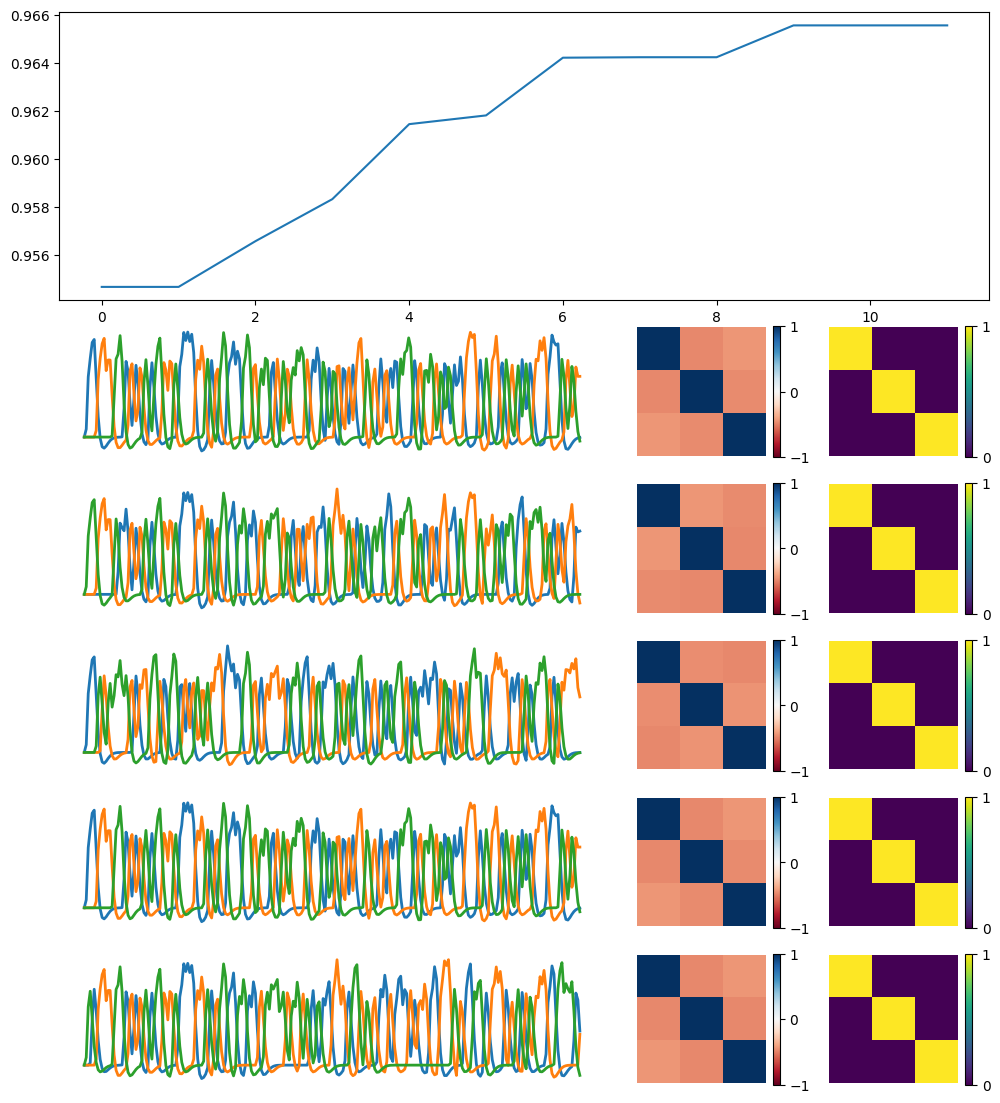

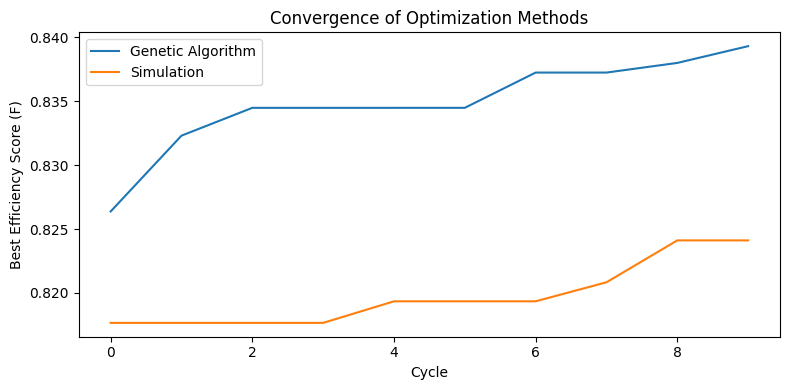

In [46]:
plt.figure(figsize=(8, 4))
plt.plot(pop_ga.optima, label="Genetic Algorithm")
plt.plot(pop_sim.optima, label="Simulation")
plt.xlabel("Cycle")
plt.ylabel("Best Efficiency Score (F)")
plt.title("Convergence of Optimization Methods")
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / "convergence.pdf")
plt.show()

### Comparing final scores

In [47]:
# Collect scores from the random baseline pool
rnd_scores = [x.F for x in pop_rnd.designs]
median_idx = np.where(rnd_scores == np.median(rnd_scores))[0][0]
rnd_median = pop_rnd.designs[median_idx]

PI_lower = np.percentile(rnd_scores, 5)
PI_upper = np.percentile(rnd_scores, 95)

print(f"GA best score:                    {pop_ga.optima[-1]:.4f}")
print(f"Simulation best score:            {pop_sim.optima[-1]:.4f}")
print(f"Random median score:              {np.median(rnd_scores):.4f}")
print(f"Random 90% prediction interval:   [{PI_lower:.4f}, {PI_upper:.4f}]")

GA best score:                    0.8393
Simulation best score:            0.8241
Random median score:              0.7364
Random 90% prediction interval:   [0.6956, 0.8121]


### Visualizing the best designs from each method

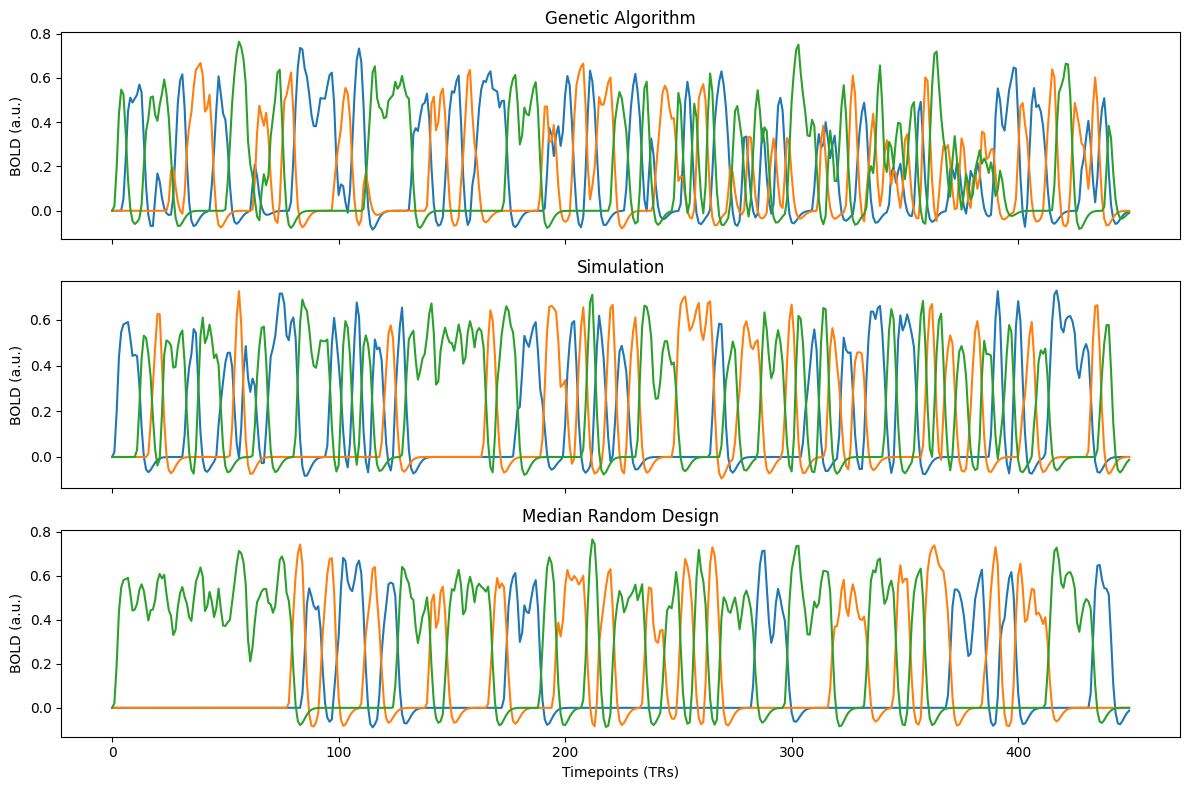

In [48]:
best_designs = [
    (pop_ga.bestdesign, "Genetic Algorithm"),
    (pop_sim.bestdesign, "Simulation"),
    (rnd_median, "Median Random Design"),
]

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for ax, (d, label) in zip(axes, best_designs):
    ax.plot(d.Xconv)
    ax.set_title(label)
    ax.set_ylabel("BOLD (a.u.)")
axes[-1].set_xlabel("Timepoints (TRs)")
plt.tight_layout()
plt.savefig(output_dir / "best_designs_comparison.pdf")
plt.show()

---

## 8 — Simulating Statistical Power (Optional, Advanced)

Beyond efficiency scores, we can evaluate designs by simulating fMRI data and running GLM analyses to estimate statistical power empirically. This requires generating synthetic BOLD signals with known beta weights and noise, then checking how often each design detects the effect.

The code below simulates data and computes t-statistics in Python. For a full R-based analysis (using `rpy2`), see the `tuto_compare_and_simulate.ipynb` notebook in the original examples.

In [49]:
from scipy.stats import t as t_dist

# Collect convolved design matrices
des_list = [pop_ga.bestdesign.Xconv, pop_sim.bestdesign.Xconv, rnd_median.Xconv]
labels = ["GA", "Simulation", "Random (median)"]

# Assumed true beta weights
betas = np.array([0.5, 0, -0.5])

# Significance threshold (one-sided, alpha=0.05)
tp = des_list[0].shape[0]
threshold = t_dist.ppf(0.95, tp - 2)

print(f"Simulating {sims} datasets per design ({tp} timepoints each)...")
print(f"True betas: {betas}")
print(f"t-threshold (one-sided, alpha=0.05): {threshold:.3f}")
print()

for des_matrix, label in zip(des_list, labels):
    # Simulate: Y = X*beta + noise
    signal = des_matrix @ betas
    detected = 0
    for _ in range(sims):
        noise = np.random.normal(0, 1, tp)
        Y = signal + noise
        # Simple OLS for the contrast (first regressor)
        X = des_matrix[:, 0]
        beta_hat = np.dot(X, Y) / np.dot(X, X)
        residuals = Y - beta_hat * X
        se = np.sqrt(np.sum(residuals**2) / (tp - 2) / np.dot(X, X))
        t_stat = beta_hat / se if se > 0 else 0
        if t_stat > threshold:
            detected += 1
    power = detected / sims
    print(f"{label:>20s}: observed power = {power:.3f}")

Simulating 50 datasets per design (450 timepoints each)...
True betas: [ 0.5  0.  -0.5]
t-threshold (one-sided, alpha=0.05): 1.648

                  GA: observed power = 0.960
          Simulation: observed power = 0.840
     Random (median): observed power = 0.700


---

## 9 — Summary and Recommendations

This tutorial covered the complete `neurodesign` workflow:

**What you learned:**

- `Experiment` objects define the fixed experimental context (TR, contrasts, ITI model).
- `Design` objects represent specific trial sequences that can be evaluated on four efficiency metrics (Fd, Fe, Fc, Ff).
- Crossover and mutation allow exploring the design space by combining and perturbing existing designs.
- `Optimisation` automates the search using either a genetic algorithm or simulation-based approach.
- The GA generally converges faster and reaches higher efficiency scores than simulation.
- Both methods substantially outperform random design selection.

**Practical tips:**

- For production runs, use `cycles >= 1000` and `preruncycles >= 100` for the GA.
- Weight selection matters: emphasizing `Fd` (detection) is common for hypothesis-driven studies, while `Fe` (estimation) is better for FIR / deconvolution analyses.
- Always compare optimized designs against a random baseline to quantify improvement.
- Use `report.make_report()` to document and share your optimization results.

**Further reading:**

- [Neurodesign GitHub repository](https://github.com/neuropower/neurodesign)
- [Neurodesign paper (Durnez et al.)](https://doi.org/10.1371/journal.pcbi.1005842)
- Original tutorial notebooks: `examples/` folder in the repository